In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from collections import Counter
import math
import pdb
path_x = 'dataset/x_train.csv'
path_t = 'dataset/t_train.csv'

In [7]:
def PCA(x, dim):
    N = x.shape[0]
    
    mean = np.mean(x, axis = 0)
    B = x - np.tile(mean, (N,1))
    cov = np.dot(B.T, B) / (N - 1) #(feature shape, feature shape)
    D, V = np.linalg.eigh(cov)
    
    idx = np.argsort(D)[::-1] # from big to small eigen values idx
    D2 = D[idx]
    V2 = V[:,idx]
    x = np.dot(x, V2[:, :dim])
    x = normalize(x)
    
    return x

def normalize(x):
    return (x - np.mean(x)) / np.std(x)



In [52]:
class SVM:
    def __init__(self, phi, decision):
        self.phi = phi
        self.decision = decision
        self.classes = [[0, 1], [0, 2], [1, 2]]

    def get_phi(self, x):
        if self.phi == 'linear':
            return x
        
        # input (N, 2)
        x = x.reshape((-1, 2))
        x_1 = x[:, 0]
        x_2 = x[:, 1]
        
        # output(3,)
        if x.shape[0] == 1:
            return np.array([x_1 ** 2, np.sqrt(2) * x_1 * x_2, x_2 ** 2]).T.reshape((-1))
        
        # output (N, 3)
        return np.array([x_1 ** 2, np.sqrt(2) * x_1 * x_2, x_2 ** 2]).T

    
    def kernel(self, x_i, x_j):
        return np.dot(self.get_phi(x_i), self.get_phi(x_j).T)
    
    def fit(self, x_train, t_train):
        self.x_train = x_train
        self.t_train = t_train
        
        clf = SVC(kernel=self.kernel, decision_function_shape=self.decision)
        clf.fit(x_train, t_train)
        self.coef = np.abs(clf.dual_coef_)
        self.sv_index = clf.support_
        
        self._set_multipliers()
        self._set_weights()
        self._set_biases()
        
    def predict(self, x_test):
        prediction = []
        for i in range(x_test.shape[0]):
            votes = []
            for j in range(3):
                y = self.weights[j].dot(self.get_phi(x_test[i])) + self.biases[j]
                if y > 0:
                    votes.append(self.classes[j][0])
                else:
                    votes.append(self.classes[j][1])
            prediction.append(Counter(votes).most_common()[0][0])
        return np.array(prediction)

    def _set_multipliers(self):
        
        multiplier = np.zeros((self.x_train.shape[0], 2))
        multiplier[self.sv_index] = self.coef.T
        
        self.t = []
        for c in self.classes:
            target = np.zeros(t_train.shape)
            target[t_train == c[0]] = 1
            target[t_train == c[1]] = -1
            self.t.append(target)
                
        a_0_1 = np.zeros(t_train.shape)
        a_0_1[t_train == 0] = multiplier[t_train == 0, 0]
        a_0_1[t_train == 1] = multiplier[t_train == 1, 0]
        
        a_0_2 = np.zeros(t_train.shape)
        a_0_2[t_train == 0] = multiplier[t_train == 0, 1]
        a_0_2[t_train == 2] = multiplier[t_train == 2, 0]
        
        a_1_2 = np.zeros(t_train.shape)
        a_1_2[t_train == 1] = multiplier[t_train == 1, 1]
        a_1_2[t_train == 2] = multiplier[t_train == 2, 1]
        
        self.a = [a_0_1, a_0_2, a_1_2]
    
    def _set_weights(self):
        self.weights = [self._weight(self.a[i], self.t[i], x_train) for i in range(3)]
        
    def _set_biases(self):
        self.biases = [self._bias2(self.a[i], self.t[i], x_train) for i in range(3)]
    
    def _weight(self, a, t, X):
        at = a * t
        w = np.dot(at, self.get_phi(X))
        return w
    
    def _bias2(self, a, t, X):
        S = a != 0
        b = 0
        for n in np.where(S)[0]:
            temp = 0
            for m in np.where(S)[0]:
                temp += a[m] * t[m] * self.kernel(X[n], X[m])
            b += t[n] - temp
        b /= np.sum(S)
        return b
    
    def _bias(self, a, t, X):
        M = np.logical_and(a > 0, a < 1)
        if np.sum(M) == 0: return -1
        S = a != 0
        b = 0
        for n in np.where(M)[0]:
            temp = 0
            for m in np.where(S)[0]:
                temp += a[m] * t[m] * self.kernel(X[n], X[m])
            b += t[n] - temp
        b /= np.sum(M)
        return b

    def plot_result(self, X, t):
        
        plt.figure()
        plt.title(f'decision type: {self.decision} phi = {self.phi}')
        plt.scatter(X[self.sv_index, 0], X[self.sv_index, 1], facecolors='none', edgecolors='k', linewidths=2, label="support vector")
        plt.scatter(X[t == 0, 0], X[t == 0, 1], c='b', marker='x', label="class 0")
        plt.scatter(X[t == 1, 0], X[t == 1, 1], c='g', marker='x', label="class 1")
        plt.scatter(X[t == 2, 0], X[t == 2, 1], c='r', marker='x', label="class 2")
        plt.legend(loc='best')
        
        x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
        y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.005),
                             np.arange(y_min, y_max, 0.005))
        pred = self.predict(np.column_stack((xx.flatten(), yy.flatten())))
        plt.contourf(xx, yy, pred.reshape(xx.shape), alpha=0.1, cmap=plt.cm.coolwarm)
        plt.show()



# Main Function

In [12]:
data_x = pd.read_csv(path_x)
data_t = pd.read_csv(path_t)

data_x = np.array(data_x)
data_t = np.array(data_t).reshape(-1)


print(data_x.shape)
print(data_t.shape)
# print(x_train.mean())


# x_train = np.loadtxt(path_x, delimiter=',')
# t_train = np.loadtxt(path_t, delimiter=',')
# print(x_train.shape)
# print(t_train.shape)

(299, 784)
(299,)


In [14]:
x_train = PCA(data_x, dim=2)
t_train = data_t
print(x_train.shape)
print(x_train.shape)

(299, 2)
(299, 2)


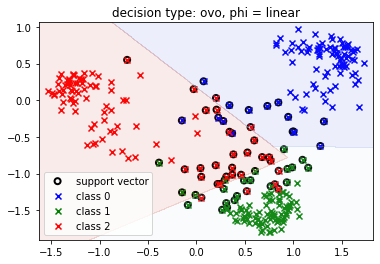

In [55]:
svm = SVM(phi='linear', decision='ovo') 
svm.fit(x_train, t_train)
svm.plot_result(x_train, t_train)

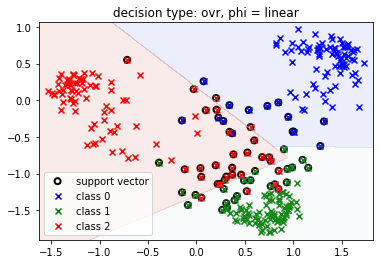

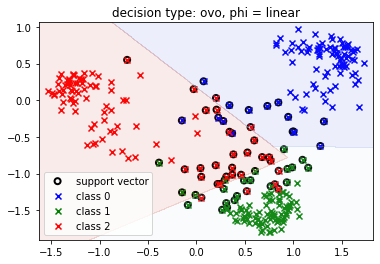

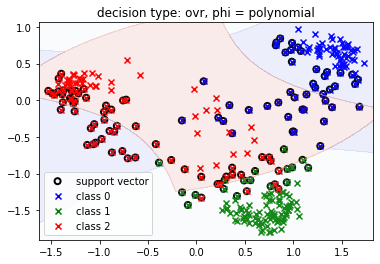

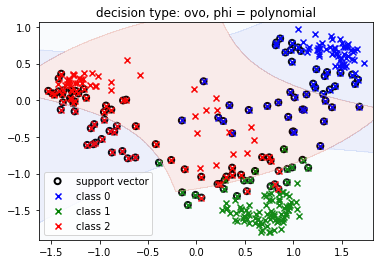

In [54]:
# hyperparameters
phi_ls = ['linear', 'polynomial']
decision_ls = ['ovr','ovo']

for PHI in phi_ls:
    for DECISION in decision_ls:
        svm = SVM(phi=PHI, decision=DECISION) 
        svm.fit(x_train, t_train)
        svm.plot_result(x_train, t_train)
        